In [ ]:
# -*- coding: utf-8 -*-
# Licensed under a 3-clause BSD style license - see LICENSE.rst
import logging
import os
import warnings
from collections import OrderedDict
from multiprocessing import Pool

import astropy
from astropy.table import Table, hstack
import astropy.units as u
from astropy.io import ascii
from astropy.constants import alpha, c, e, hbar, m_e, m_p, sigma_sb
from astropy.utils.data import get_pkg_data_filename
from astropy.cosmology import WMAP9 as cosmo

import numpy as np
import matplotlib.pyplot as plt

from Validator import (
    validate_array,
    validate_physical_type,
    validate_scalar,
)
#from .model_utils import memoize
from Utils import trapz_loglog
from
import Models
import Radiative
import grbloader
from GRBmodel import GRBModel1
from GRBmodelstr import GRBModel_topstruc
from Models import EblAbsorptionModel

from astropy.units import def_physical_type

try:
    #def_physical_type(u.Unit("1 / eV"), "differential energy")
    def_physical_type(u.erg / u.cm**2 / u.s, "flux")
    def_physical_type(u.Unit("1/(s cm2 erg)"), "differential flux")
    def_physical_type(u.Unit("1/(s erg)"), "differential power")
    def_physical_type(u.Unit("1/TeV"), "differential energy")
    def_physical_type(u.Unit("1/cm3"), "number density")
    def_physical_type(u.Unit("1/(eV cm3)"), "differential number density")

except ValueError:
    print("New quantities already defined")

New quantities already defined


F(t_obs) = 0.41027030757156296


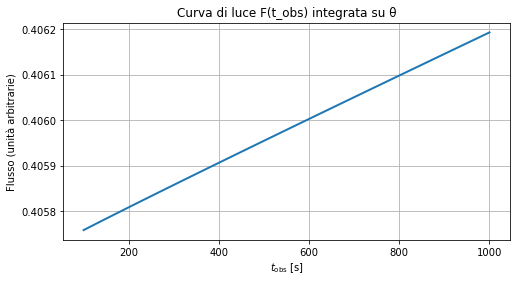

In [18]:
import numpy as np
from scipy.optimize import brentq
from scipy.integrate import simps

c = 2.99792458e10  # cm/s
mpc2_erg = 1.0     # <-- metti qui il tuo valore corretto

# --- le tue funzioni ---
def gammaval(Eiso, density, avtime, scenario='ISM'):
    if scenario == 'ISM':
        gamma = (1. / 8.) ** (3. / 8.) * (3.0 * Eiso / (4.0 * np.pi * density * mpc2_erg * ((c * avtime) ** 3.0))) ** 0.125
        radius = 8. * c * avtime * gamma**2
    else:
        raise ValueError("Scenario non riconosciuto")
    return gamma, radius

def doppler(gamma, theta_rad):
    if gamma <= 1.0:
        return 0.0
    beta = np.sqrt(1.0 - 1.0/gamma**2)
    return 1.0 / (gamma * (1.0 - beta*np.cos(theta_rad)))

# --- equazione per trovare il tempo di emissione ---
def emission_time_for_theta(t_obs, theta, Eiso, density, z, tmin=1e-3, tmax=1e7):
    def f(t):
        gamma, R = gammaval(Eiso, density, t)
        return (1+z)*(t - R*np.cos(theta)/c) - t_obs
    try:
        return brentq(f, tmin, tmax)
    except ValueError:
        return None

def flux_at_tobs(t_obs, Eiso, density, z=0.0, ntheta=200):
    thetas = np.linspace(0, np.pi/2, ntheta)
    integrand = []
    for th in thetas:
        t_em = emission_time_for_theta(t_obs, th, Eiso, density, z)
        if t_em is None:
            integrand.append(0.0)
            continue
        gamma, R = gammaval(Eiso, density, t_em)
        if gamma <= 1.0:
            integrand.append(0.0)
            continue
        D = doppler(gamma, th)
        contrib = 1.0   # placeholder
        integrand.append((D**2) * contrib * np.sin(th))
    return 2*np.pi*simps(integrand, thetas)

# --- esempio ---
Eiso = 1e53     # erg
density = 1.0   # cm^-3
z = 1.0
t_obs = 1e4     # s

F_val = flux_at_tobs(t_obs, Eiso, density, z=z, ntheta=200)
print("F(t_obs) =", F_val)


# --- intervallo t_obs realistico ---
t_obs_array = np.linspace(100, 1000, 50)  # s
F_vals = []

for t_obs in t_obs_array:
    F = flux_at_tobs(t_obs, Eiso, density, z=z, ntheta=200)
    F_vals.append(F)

F_vals = np.array(F_vals)

# filtra eventuali zeri
mask = F_vals > 0

# --- plot lineare ---
plt.figure(figsize=(8,4))
plt.plot(t_obs_array[mask], F_vals[mask], lw=2)
plt.xlabel(r'$t_{\rm obs}$ [s]')
plt.ylabel('Flusso (unità arbitrarie)')
plt.title('Curva di luce F(t_obs) integrata su θ')
plt.grid(True)
plt.show()



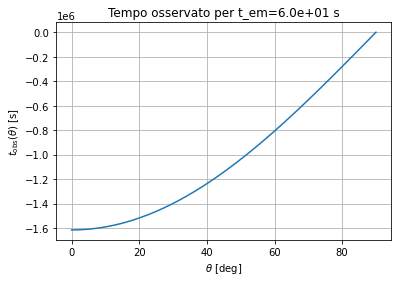

In [5]:
# Parametri
Eiso = 1e53
density = 1.0
z = 1.0
t_em = 60  # tempo di emissione fissato (s)

# Calcolo gamma e raggio
gamma, R = gammaval(Eiso, density, t_em)

thetas = np.linspace(0, np.pi/2, 200)
t_obs_vals = (1+z)*(t_em - R*np.cos(thetas)/c)

plt.figure(figsize=(6,4))
plt.plot(thetas*180/np.pi, t_obs_vals)
plt.xlabel(r"$\theta$ [deg]")
plt.ylabel(r"$t_{\rm obs}(\theta)$ [s]")
plt.title(f"Tempo osservato per t_em={t_em:.1e} s")
plt.grid()
plt.show()

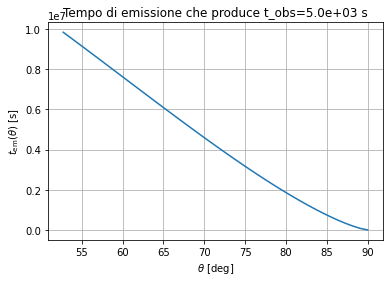

In [7]:
t_obs = 5e3  # tempo osservato fisso
thetas = np.linspace(0, np.pi/2, 100)

t_em_vals = []
for th in thetas:
    t_em = emission_time_for_theta(t_obs, th, Eiso, density, z)
    if t_em is None:
        t_em_vals.append(np.nan)
    else:
        t_em_vals.append(t_em)

plt.figure(figsize=(6,4))
plt.plot(thetas*180/np.pi, t_em_vals)
plt.xlabel(r"$\theta$ [deg]")
plt.ylabel(r"$t_{\rm em}(\theta)$ [s]")
plt.title(f"Tempo di emissione che produce t_obs={t_obs:.1e} s")
plt.grid()
plt.show()

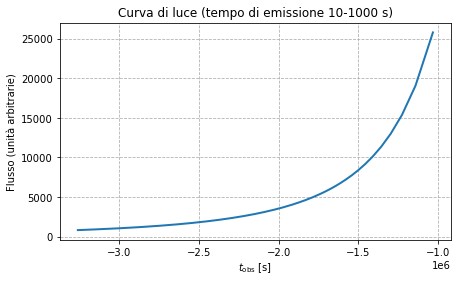

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Parametri
Eiso = 1e53
density = 1.0
z = 1.0

# Intervallo tempo emissione
t_lab = np.linspace(10, 1000, 200)  # tempo nel frame GRB [s]
t_obs_array = []
F_obs = []

for t in t_lab:
    gamma, R = gammaval(Eiso, density, t)
    if gamma <= 1.0:
        F_obs.append(0.0)
        t_obs_array.append((1+z)*t)
        continue

    # tempo osservato per theta=0
    t_obs = (1+z)*(t - R/c)
    t_obs_array.append(t_obs)

    # flusso semplificato
    D = doppler(gamma, 0.0)  # theta=0
    F_obs.append(D**2)       # placeholder per emissività

# Converti in array
t_obs_array = np.array(t_obs_array)
F_obs = np.array(F_obs)

# Filtra eventuali zero per log-log
mask = F_obs > 0

# --- plot ---
plt.figure(figsize=(7,4))
plt.plot(t_obs_array[mask], F_obs[mask], lw=2)
plt.xlabel(r'$t_{\rm obs}$ [s]')
plt.ylabel('Flusso (unità arbitrarie)')
plt.title('Curva di luce (tempo di emissione 10-1000 s)')
plt.grid(True, which='both', ls='--')
plt.show()
